In [33]:
import pandas as pd 
import numpy as py 
import datetime 
import matplotlib.pyplot as plt 
import sklearn as sk 
import scipy as sp 
import baostock as bs 
import seaborn as sns 

In [34]:
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Arial Unicode MS']  # Mac常用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
pd.options.display.float_format = '{:.2f}'.format


In [35]:
tables=pd.read_html("https://s.askci.com/stock/financialanalysis/003030",header=0)

In [36]:
df_cost=tables[3]
df_cost

,类别\年份,营业成本 （元),销售费用 （元),管理费用 （元),财务费用 （元)
0,2013,7.60亿,1.58亿,7527.54万,2858.55万
1,2014,7.68亿,1.61亿,6470.15万,2725.30万
2,2015,7.78亿,1.65亿,5772.93万,2602.59万
3,2016,8.27亿,1.68亿,5280.43万,2045.20万
4,2017,8.13亿,1.62亿,5181.31万,1817.51万
5,2018,8.61亿,1.87亿,5380.90万,2052.01万
6,2019,9.39亿,2.13亿,5726.03万,2162.63万
7,2020,11.00亿,1.87亿,5696.68万,1560.68万
8,2021,12.70亿,1.96亿,6394.54万,514.32万
9,2022,14.43亿,2.27亿,6952.79万,779.39万


In [37]:
def convert_unit(value):
    """带单位字符串转浮点数（统一转换为亿元单位）"""
    if pd.isna(value) or value == "":
        return 0.0  # 处理空值
    if '亿' in value:
        return float(value.replace('亿', ''))
    elif '万' in value:
        return float(value.replace('万', '')) / 10000
    else:
        return float(value)

# 应用转换函数到数值列
numeric_cols = ['营业成本 （元)', '销售费用 （元)','管理费用 （元)','财务费用 （元)']
for col in numeric_cols:
    df_cost[col] = df_cost[col].apply(convert_unit)

## 交互式功能重要一步

In [38]:
import matplotlib
#matplotlib.use('TkAgg')  # 替换为Qt5Agg、GTK3Agg等可用后端

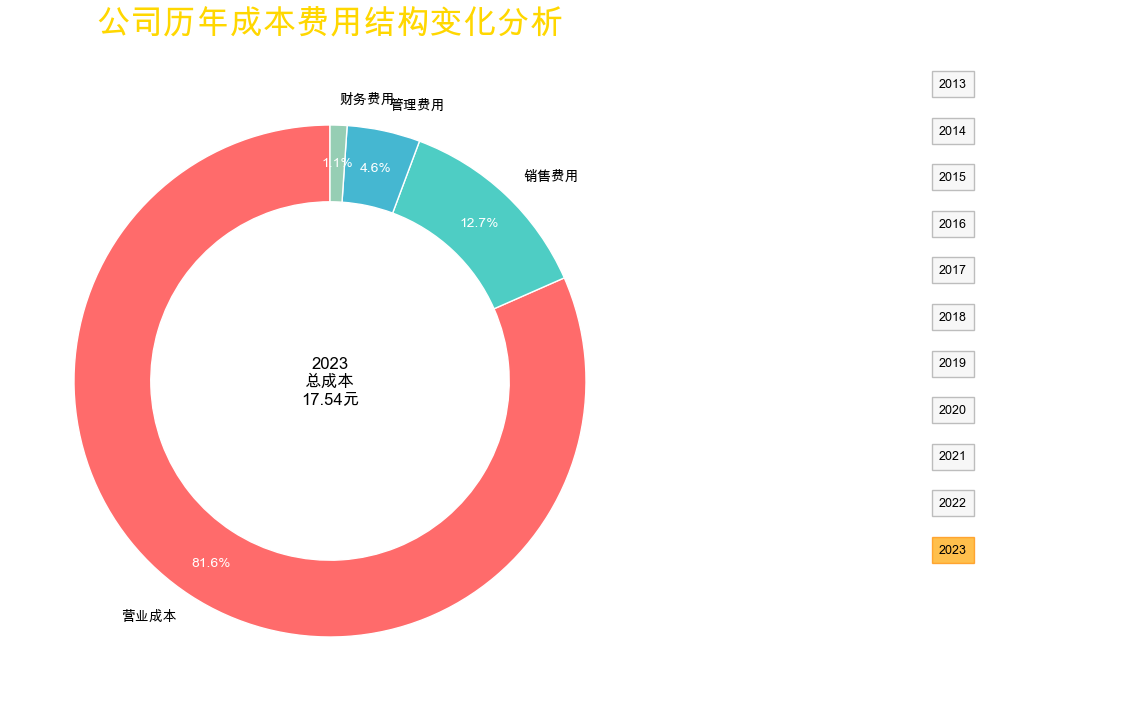

In [39]:
from matplotlib import animation
from matplotlib.widgets import Button
df = pd.DataFrame(df_cost)

# 设置可视化参数
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
categories = ['营业成本', '销售费用', '管理费用', '财务费用']

# 创建画布和主图表区域
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8])  # 主图表区域
plt.subplots_adjust(right=0.7)  # 右侧留白

# 创建年份选择面板
year_panel = fig.add_axes([0.72, 0.1, 0.25, 0.8])  # 年份选择面板
year_panel.axis('off')

# 生成年份按钮
years = df['类别\年份'].tolist()
button_height = 0.8 / len(years)  # 动态计算按钮高度
buttons = []

for idx, year in enumerate(years):
    btn = year_panel.text(
        0.5, 1 - (idx+0.5)*button_height,  # 垂直居中排列
        str(year),
        ha='center', va='center',
        fontsize=9,
        bbox=dict(facecolor='#F0F0F0', edgecolor='gray', alpha=0.5, pad=5),
        picker=True  # 启用拾取功能
    )
    buttons.append(btn)

# 初始化环形饼图
def create_donut(year):
    ax.clear()
    data = df[df['类别\年份'] == year].iloc[:, 1:].values.flatten()
    total = data.sum()
    percentages = data / total * 100
    
    # 绘制环形饼图
    wedges, texts, autotexts = ax.pie(
        percentages,
        wedgeprops=dict(width=0.3, edgecolor='w'),
        labels=categories,
        colors=colors,
        autopct='%.1f%%',
        pctdistance=0.85,
        startangle=90
    )
    
    # 设置中心文字
    ax.text(0, 0, f"{year}\n总成本\n{total:.2f}元", 
            ha='center', va='center', fontsize=12)
    
    # 样式优化
    plt.setp(autotexts, size=10, weight='bold', color='white')
    plt.setp(texts, size=10)
    ax.set_title(f'公司历年成本费用结构变化分析', fontweight='bold',fontsize=24, pad=20,color='gold')
    
# 交互逻辑
current_year = 2023  # 初始显示年份
highlight_box = dict(facecolor='#FFA500', edgecolor='darkorange', alpha=0.7, pad=5)

def on_pick(event):
    global current_year
    if event.artist in buttons:
        # 清除旧的高亮效果
        for btn in buttons:
            btn.set_bbox(dict(facecolor='#F0F0F0', edgecolor='gray', alpha=0.5, pad=5))
        
        # 设置新选择年份的高亮
        selected_year = int(event.artist.get_text())
        event.artist.set_bbox(highlight_box)
        
        # 更新主图表
        if selected_year != current_year:
            current_year = selected_year
            create_donut(selected_year)
            fig.canvas.draw()

# 绑定事件
fig.canvas.mpl_connect('pick_event', on_pick)

# 初始显示
create_donut(current_year)
buttons[-1].set_bbox(highlight_box)  # 高亮初始年份

plt.show()

### 初步解锁DASH

In [51]:
import dash
from dash import dcc, html, Input, Output, State
import plotly.graph_objs as go
import pandas as pd
import dash_bootstrap_components as dbc

# 初始化Dash应用‌:ml-citation{ref="5,8" data="citationList"}
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server 

In [52]:
df_cost.columns

Index(['类别\年份', '营业成本 （元)', '销售费用 （元)', '管理费用 （元)', '财务费用 （元)'], dtype='object')

In [53]:
df = pd.DataFrame(df_cost)
categories = ['营业成本 （元)', '销售费用 （元)', '管理费用 （元)', '财务费用 （元)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']


In [54]:
# 生成年份按钮矩阵
year_buttons = [
    dbc.Button(
        str(year), 
        id={'type': 'year-btn', 'index': year},
        className="m-1",
        style={'width': '80px', 'background-color': '#F0F0F0'}
    ) for year in df['类别\年份'] ]

In [55]:
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(
            dcc.Graph(id='cost-pie-chart'), 
            width=8
        ),
        dbc.Col([
            html.H4("选择年份", className="text-center mb-3"),
            html.Div(
                year_buttons,
                style={'maxHeight': '500px', 'overflowY': 'auto'}
            )
        ], width=4)
    ])], fluid=True)

In [56]:
@app.callback(
    Output('cost-pie-chart', 'figure'),
    [Input({'type': 'year-btn', 'index': dash.ALL}, 'n_clicks')],
    [State('cost-pie-chart', 'figure')]
)
def update_chart(_, current_fig):
    ctx = dash.callback_context
    if not ctx.triggered:
        selected_year = 2023
    else:
        selected_year = int(ctx.triggered['prop_id'].split('.').split(':')[-1])
    
    # 更新按钮样式
    for btn in year_buttons:
        if btn.id['index'] == selected_year:
            btn.style['background-color'] = '#FFA500'
        else:
            btn.style['background-color'] = '#F0F0F0'
    
    # 生成新图表
    year_data = df[df['类别\年份'] == selected_year].iloc[:, 1:].values.flatten()
    total = year_data.sum()
    
    return {
        'data': [go.Pie(
            values=year_data,
            labels=categories,
            hole=0.5,
            marker_colors=colors,
            textinfo='percent',
            insidetextorientation='radial'
        )],
        'layout': go.Layout(
            annotations=[
                dict(
                    text=f"{selected_year}<br>总成本<br>{total:.2f}元",
                    x=0.5, y=0.5,
                    font_size=16,
                    showarrow=False
                )
            ]
        ) 
    }


In [57]:
if __name__ == '__main__':
    app.run(debug=True)

Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

In [58]:
import socket  

def is_port_in_use(port: int) -> bool:  
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:  
        return s.connect_ex(('localhost', port)) == 0  

if is_port_in_use(8050):  
    print("端口已被占用，自动切换至8051")  
    app.run(port=8051)  
else:  
    app.run(port=8050)  


端口已被占用，自动切换至8051
